<a href="https://colab.research.google.com/github/Ulisman/Sentiment-analysis/blob/main/Sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install tensorflow_text

In [ ]:
import csv
import string
import numpy as np
import tensorflow as tf
import gensim
from nltk.corpus import stopwords
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from gensim.models import Word2Vec, KeyedVectors
import tensorflow_hub as hub
import tensorflow_text as text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Data- preprocessing and exploration

In [ ]:
#Loading all the data
labels = []
sentences = []
with open('review-sentiments.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=';')
  for row in reader:
    labels.append(int(row[0]))
    sentences.append(row[1])


In [ ]:
#Loading with only two labels - binary classification:
labels = []
sentences = []
with open('review-sentiments.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=';')
  for row in reader:
    label = int(row[0])
    if label == 1 or label == 2: #The excellent and good ratings get assigned the label "0"
      labels.append(0)
      sentences.append(row[1])
    elif label == 4 or label == 5: #The poor and terrible ratings get assinged the label "1"
      labels.append(1)
      sentences.append(row[1])
    else: #Average ratings are not used becuase they have very mixed signals
      pass

In [ ]:
len(sentences) #28266 unique reviews in the dataset when we load with only two labels

28266

In [ ]:
#Finding how many instances of each label there are in the dataset using pandas value_counts
import pandas as pd
uniques = pd.Series(labels)
uniques.value_counts()

#Conlcusion: The dataset is slightly imblanced

1    14469
0    13797
dtype: int64

In [ ]:
#Cleaning the text by removing '\n', stopwords and punctuations
stop_words = set(stopwords.words('english'))

def clean(sentence_list):
  arr = []
   #remove "\n" from the sentences
  punctuations = str.maketrans('', '', string.punctuation) #remove punctuations from the sentences
  for sentence in sentence_list:
    sentence = sentence.replace('\n', ' ')
    sentence = sentence.replace('...More', ' ') #Some of the scraped review-texts did not get fully scraped, so this will remove the '...More' ending that appears in those review-texts
    sentence_stopwords = ''
    for word in sentence.split(' '):
      if word not in stop_words: #Removes stopwords
        sentence_stopwords += word + " "
    sentence_cleaned = sentence_stopwords.translate(punctuations)
    arr.append(sentence_cleaned.lower())
  return arr

In [ ]:
cleaned_sentences = clean(sentences)

print("Before: ", sentences[2])
print("After: ", cleaned_sentences[2])

Before:  Piccolo is outstanding
Simply love the food here.  Accommodating outdoor seating with Covid. 
Tiramisu is delicious
After:  piccolo outstanding simply love food here  accommodating outdoor seating covid  tiramisu delicious 


In [ ]:
#Splitting the data into training and testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(cleaned_sentences, labels, test_size=1/3, random_state=42)

In [ ]:
len(X_train)

18844

### Tokenization

In [ ]:
#Tokenizing and sequenceing the data. This is basically swapping the words of a sentence out with an integer that represents that word
max_len = 150# max(len(sent) for sent in training_sentences)
trunc_type = 'post'
padding_type = 'post'

tokenizer = Tokenizer(num_words=2500, oov_token='<OOV>') #"num_words=1000" chooses the top 1000 words by volume
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(X_train) #
training_sequences_padded = pad_sequences(training_sequences, maxlen=max_len, padding=padding_type)

test_sequences = tokenizer.texts_to_sequences(X_test)
test_sequences_padded = pad_sequences(test_sequences, maxlen=max_len, padding=padding_type)

In [ ]:
#Converting to ndarrays
training_sequences_padded = np.array(training_sequences_padded)
training_labels = np.array(y_train)
test_sequences_padded = np.array(test_sequences_padded)
test_labels = np.array(y_test)

#reshaping label to 2d-tensor:
#training_labels = np.asarray(y_train).astype('float32').reshape((-1,1))
#test_labels = np.asarray(y_test).astype('float32').reshape((-1,1))

In [ ]:
#Parameters:
embedding_dim = 100
vocab_size = 2500 + 1#len(word_index) + 1 #2000 best results so far

### Testing machinge learning algorithms




> Traditional machine learning algorithms can perform better than deep neural networks in some cases. Therefore I wanted to compare them




In [ ]:
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

def accuracy(alg, xtrain, ytrain, xtest, ytest):
  cv = cross_val_score(alg, xtrain, ytrain, cv=5)
  print("Cross-val: ", cv.mean())

  alg.fit(xtrain, ytrain)
  ypred = alg.predict(xtest)
  print("Accuracy_score: ", accuracy_score(ytest, ypred))

In [ ]:
xgb = XGBClassifier(n_estimators=100)
accuracy(xgb, training_sequences_padded, training_labels, test_sequences_padded, test_labels)

Cross-val:  0.6234346825341834
Accuracy_score:  0.6272553597962216


In [ ]:
rf = RandomForestClassifier(random_state=42)
accuracy(rf, training_sequences_padded, training_labels, test_sequences_padded, test_labels)

Cross-val:  0.6336764638781343
Accuracy_score:  0.6404160475482912


In [ ]:
#XGBoost and RandomForest do not need scaled data becuase they are essentially made up of many decision trees which do not use gradient descent for optimization
from sklearn import preprocessing 

scaler = preprocessing.StandardScaler().fit(training_sequences_padded)
scaled_xtrain = scaler.transform(training_sequences_padded)
scaled_xtest = scaler.transform(test_sequences_padded)

In [ ]:
lr = LogisticRegression(max_iter=1000)
accuracy(lr, scaled_xtrain, training_labels, scaled_xtest, test_labels)

Cross-val:  0.5984391045736281
Accuracy_score:  0.5995542347696879


In [ ]:
nb = GaussianNB()
accuracy(nb, scaled_xtrain, training_labels, scaled_xtest, test_labels)

Cross-val:  0.5646355000199977
Accuracy_score:  0.5759923583103375


### Using LSTM

In [ ]:
model = tf.keras.Sequential([
  keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_len),
  keras.layers.LSTM(150),
  keras.layers.Dense(100, activation='relu'),
  keras.layers.Dense(1, activation='sigmoid')
])

adam = keras.optimizers.Adam()

model.compile(
    loss='binary_crossentropy',
    optimizer=adam,
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 150, 100)          250100    
_________________________________________________________________
lstm (LSTM)                  (None, 150)               150600    
_________________________________________________________________
dense_2 (Dense)              (None, 100)               15100     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 415,901
Trainable params: 415,901
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(training_sequences_padded, training_labels, batch_size=32, epochs=16, validation_split=0.2, verbose=1)

Epoch 1/16
472/472 [==============================] - 114s 238ms/step - loss: 0.6862 - accuracy: 0.5213 - val_loss: 0.6846 - val_accuracy: 0.5150
Epoch 2/16
472/472 [==============================] - 113s 239ms/step - loss: 0.6766 - accuracy: 0.5157 - val_loss: 0.6857 - val_accuracy: 0.5113
Epoch 3/16
472/472 [==============================] - 116s 246ms/step - loss: 0.6709 - accuracy: 0.5297 - val_loss: 0.6840 - val_accuracy: 0.5150
Epoch 4/16
472/472 [==============================] - 111s 236ms/step - loss: 0.6706 - accuracy: 0.5266 - val_loss: 0.6974 - val_accuracy: 0.5150
Epoch 5/16
472/472 [==============================] - 109s 231ms/step - loss: 0.6302 - accuracy: 0.5895 - val_loss: 0.5042 - val_accuracy: 0.7819
Epoch 6/16
472/472 [==============================] - 112s 237ms/step - loss: 0.4132 - accuracy: 0.8266 - val_loss: 0.3774 - val_accuracy: 0.8315
Epoch 7/16
472/472 [==============================] - 112s 237ms/step - loss: 0.3250 - accuracy: 0.8742 - val_loss: 0.3536 -

### LSTM Results

In [ ]:
#Plotting the results of the LSTM model
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_' + string])
  plt.xlabel('epochs')
  plt.ylabel(string)
  plt.legend([string, 'val_' + string])
  plt.show()

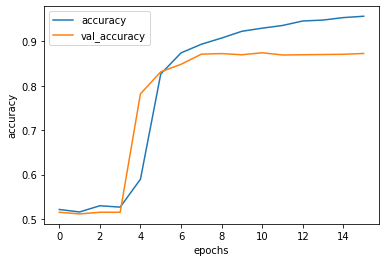

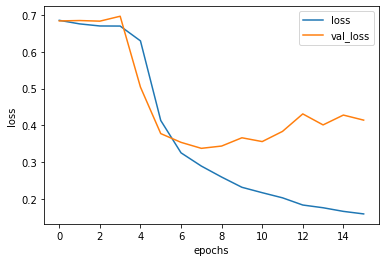

295/295 [==============================] - 17s 58ms/step - loss: 0.4188 - accuracy: 0.8689
Acc:  0.8689237833023071
Loss:  0.41878387331962585


In [ ]:
plot_graphs(model.history, 'accuracy') 
plot_graphs(model.history, 'loss')
score = model.evaluate(test_sequences_padded, test_labels) 
print("Acc: ", score[1])
print("Loss: ", score[0]) 

In [ ]:
#Trying out some predictions:
def make_pred(review):
  cleaned_review = clean([review])
  print(cleaned_review)
  pred_seq = tokenizer.texts_to_sequences(cleaned_review)
  pred_seq_padded = pad_sequences(pred_seq, maxlen=max_len, padding=padding_type)
  pred_seq_padded = np.array(pred_seq_padded)
  y_pred = model.predict(pred_seq_padded)
  print(y_pred)
  print(round(y_pred[0][0])) #The sigmoid actiavtion function returns a probability between 0 and 1 and where everything over 0.5 represent the prediction of label 1, and everything under represents the prediction of label 0

In [ ]:
rev = 'This was one of the best restaurants I have ever been to. The food tasted great. The servcie was very good aswell. It was delicious. Love to eat'
pred = make_pred(rev)

['this one best restaurants i ever to the food tasted great the servcie good aswell it delicious love eat ']
[[0.05344683]]
0


### BERT


> BERT is a pretrained transformer created by Google. Transformers are a state-of-the-art deep learning architecture so I wanted to test the performance with this dataset



In [ ]:
#Loading the model from tensorflow hub
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4')

def get_sentence_embedding(text):
  preprocessed_text = bert_preprocess(text)
  return bert_encoder(preprocessed_text)['pooled_output']

In [ ]:
#The model
text_input = keras.layers.Input(shape=(), dtype=tf.string)
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

x = keras.layers.Dropout(0.1)(outputs['pooled_output'])
x = keras.layers.Dense(100, activation='relu')(x)
x = keras.layers.Dense(1, activation='sigmoid')(x)

bert_model = keras.Model(inputs=[text_input], outputs=[x])

bert_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)


bert_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        {'input_type_ids': ( 0           input_3[0][0]                    
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      {'default': (None, 7 109482241   keras_layer[2][0]                
                                                                 keras_layer[2][1]                
                                                                 keras_layer[2][2]                
____________________________________________________________________________________________

In [ ]:
bert_model.fit(X_train, y_train, epochs=15)

Epoch 1/15
589/589 [==============================] - 201s 338ms/step - loss: 0.5687 - accuracy: 0.6980
Epoch 2/15
589/589 [==============================] - 199s 337ms/step - loss: 0.5100 - accuracy: 0.7506
Epoch 3/15
589/589 [==============================] - 199s 337ms/step - loss: 0.4946 - accuracy: 0.7650
Epoch 4/15
589/589 [==============================] - 199s 337ms/step - loss: 0.4876 - accuracy: 0.7694
Epoch 5/15
589/589 [==============================] - 199s 337ms/step - loss: 0.4872 - accuracy: 0.7690
Epoch 6/15
589/589 [==============================] - 199s 337ms/step - loss: 0.4818 - accuracy: 0.7724
Epoch 7/15
589/589 [==============================] - 199s 337ms/step - loss: 0.4786 - accuracy: 0.7758
Epoch 8/15
589/589 [==============================] - 199s 337ms/step - loss: 0.4745 - accuracy: 0.7781
Epoch 9/15
589/589 [==============================] - 199s 337ms/step - loss: 0.4736 - accuracy: 0.7747
Epoch 10/15
589/589 [==============================] - 198s 337m

In [ ]:
bert_score = bert_model.evaluate(X_test, y_test)
print("Acc: ", bert_score[1])
print("Loss: ", bert_score[0])

#Result was not quite as good as using LSTMs

295/295 [==============================] - 100s 338ms/step - loss: 0.4485 - accuracy: 0.7965
Acc:  0.7965400218963623
Loss:  0.44850948452949524


### Saving the model and the tokenizer for deployment

In [ ]:
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [ ]:
model.save('model.h5')

In [ ]:
new_model = tf.keras.models.load_model('model.h5')

In [ ]:
new_score = new_model.evaluate(test_sequences_padded, test_labels) 
print("Acc: ", new_score[1])
print("Loss: ", new_score[0]) 

295/295 [==============================] - 17s 56ms/step - loss: 0.4188 - accuracy: 0.8689
Acc:  0.8689237833023071
Loss:  0.41878387331962585


In [ ]:
#Testing the model
rev = "The food was disgusting and the service was awful. I never want to go back again"
cleaned_review = clean([rev])
pred_seq = tokenizer.texts_to_sequences(cleaned_review)
pred_seq_padded = pad_sequences(pred_seq, maxlen=max_len, padding=padding_type)
pred_seq_padded = np.array(pred_seq_padded)
print(pred_seq_padded[0][:10])
a = new_model.predict(pred_seq_padded)
print(a[0][0])

[  3   4 765   7 409   2  54 109  16  23]
0.9864112


In [ ]:
#Downloading the model file
from google.colab import files
files.download('model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>